# Modelo

## Datos

In [272]:
#NP = (110119 + 109164 + 111111) / 3 
NP = 110119 
A_TERR = 17.32 * NP / 3000

A_SOT = 8.66 ** 2                   #  Area del sotano (m2)
Q_MAX = 8                           #  Caudal maximo de la bomba (m^3/h)
D_H_MAX = 4                         #  Desnivel maximo de la bomba (m)
D_H_MIN = 1                         #  Desnivel minimo de la bomba (m)
H_SOT = 3.50                        #  Altura del sotano (m) 
V_SOT = H_SOT * A_SOT               #  Volumen del sotano (m3)

C_SAT = 0.90                        # Coeficiente de infiltracion con el suelo saturado (admin)
C_0 = 0.60                          # Coeficiente de infiltracion inicial (admin)

T_K = (1-NP/140000)                 # Tiempo caracteristico (h)

## Ecuaciones

In [273]:
# EC 1
def f_derivada_volumen(q_ent, q_sal):
    return q_ent - q_sal


# EC 2
def f_caudal_entrada(c, i, a_terr):
    return c * i * a_terr  # admin * m/h * m2 = m3/h


# EC 3
def f_caudal_salida(q_max, d_h_max, d_h_min, d_h):
    if d_h_max < d_h:
        raise ValueError(
            "Se intenta calcular el caudal de salida con una altura negativa"
        )
    if d_h < d_h_min:
        return 0    # la bomba no funciona
    return q_max * (((d_h_max - d_h) / (d_h_max - d_h_min)) ** 0.5)


# EC 4
def f_desnivel_agua(h_s, h):
    return h_s - h


# EC 5
def f_altura_agua(v, a_sot):
    return v / a_sot


# EC 6
def f_derivada_infiltracion(v, v_sot, t_k, c_sat, c):
    return (v / (v_sot * t_k)) * (c_sat - c)

## Métodos

In [274]:
def euler_explicito(f, u, t, h):
    return u + h * f(u, t)

def euler_explicito_2(f, g, u, v, t, h):
    return u + h * f(u, v, t), v + h * g(u, v, t)

def runge_kutta_2(f, g, u, v, t, h):
    q1_u = h * f(u, v, t)
    q1_v = h * g(u, v, t)

    q2_u = h * f(u + q1_u, v + q1_v, t + h)
    q2_v = h * g(u + q1_u, v + q1_v, t + h)
    
    return u + 0.5 * (q1_u + q2_u), v + 0.5 * (q1_v + q2_v)

def runge_kutta_4(f, g, u, v, t, h):
    q1_u = h * f(u, v, t)
    q1_v = h * g(u, v, t)

    q2_u = h * f(u + 0.5 * q1_u, v + 0.5 * q1_v, t + 0.5 * h)
    q2_v = h * g(u + 0.5 * q1_u, v + 0.5 * q1_v, t + 0.5 * h)

    q3_u = h * f(u + 0.5 * q2_u, v + 0.5 * q2_v, t + 0.5 * h)
    q3_v = h * g(u + 0.5 * q2_u, v + 0.5 * q2_v, t + 0.5 * h)

    q4_u = h * f(u + q3_u, v + q3_v, t + h)
    q4_v = h * g(u + q3_u, v + q3_v, t + h)
    
    return u + (q1_u + 2 * q2_u + 2 * q3_u + q4_u) / 6, v + (q1_v + 2 * q2_v + 2 * q3_v + q4_v) / 6

## A.1
Discretizar la ec. 1 con el método de Euler, tomando $C$ = 1, $Q$ = 0. Correr el modelo para la precipitación de 60 min y verificar que el volumen de agua almacenado en el sótano coincida con el volumen de lluvia.

In [275]:
intensidad_tormenta = 85.0 / 1000  # m/h
duracion_tormenta = 1  # h
infiltracion = 1  # a-dimensional
caudal_salida = 0  # m3/h

def d_volumen(tiempo, volumen):
    caudal_de_entrada = f_caudal_entrada(infiltracion, intensidad_tormenta, A_TERR)  # m3/h
    return f_derivada_volumen(caudal_de_entrada, caudal_salida) # m3/h

paso_de_tiempo = 1 / 60  # h

volumen_de_agua = 0  # m3
tiempo_actual = 0  # h

volumenes = []
tiempos = []

while tiempo_actual <= duracion_tormenta:
    volumen_de_agua = euler_explicito(d_volumen, volumen_de_agua, tiempo_actual, paso_de_tiempo)
    tiempo_actual += paso_de_tiempo
    
    volumenes.append(volumen_de_agua)
    tiempos.append(tiempo_actual)

print(f"Final volume: {round(volumen_de_agua, 2)} m3")

Final volume: 54.04 m3


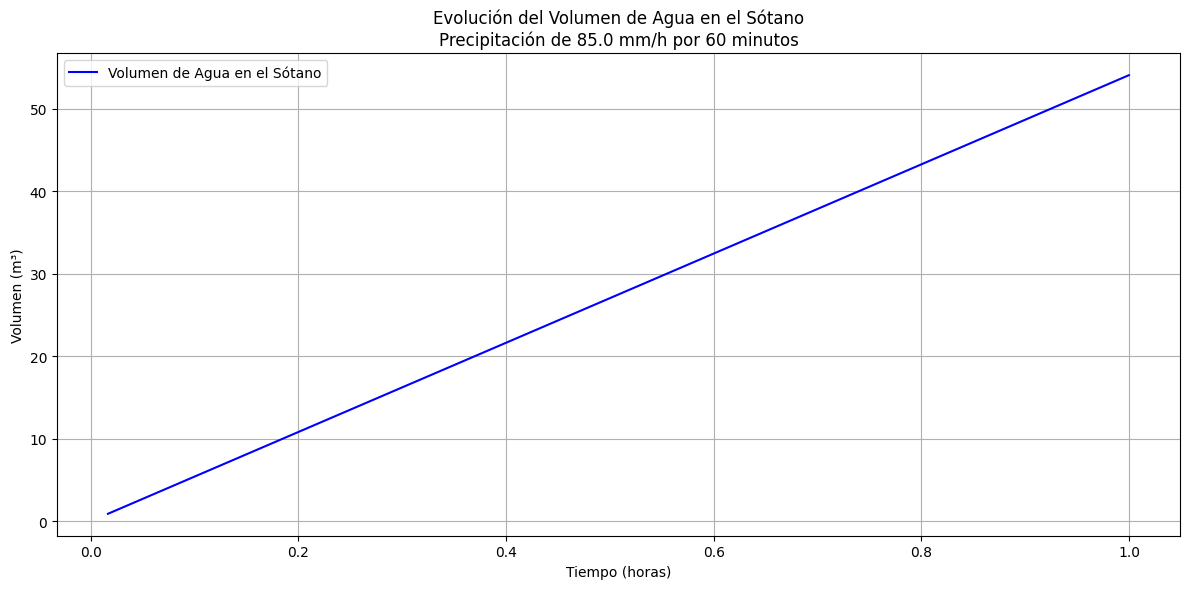

In [276]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(tiempos, volumenes, label='Volumen de Agua en el Sótano', color='blue')
# plt.axhline(y=V_SOT, color='r', linestyle='--', label='Volumen Máximo del Sótano')
plt.xlabel('Tiempo (horas)')
plt.ylabel('Volumen (m³)')
plt.title(f'Evolución del Volumen de Agua en el Sótano\nPrecipitación de {intensidad_tormenta*1000} mm/h por {duracion_tormenta*60} minutos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Funciones que usaremos como f y g

In [277]:
intensidad = 85.0 / 1000  # m/h

def d_volumen(volumen, infiltracion, tiempo):
    area_del_terreno = A_TERR

    flujo_maximo = Q_MAX
    d_altura_maxima = D_H_MAX
    d_altura_minima = D_H_MIN

    altura_sotrano = H_SOT
    area_sotano = A_SOT
    volumen = f_altura_agua(volumen, area_sotano)

    desnivel_agua = f_desnivel_agua(altura_sotrano, volumen)
    caudal_entrada = f_caudal_entrada(infiltracion, intensidad, area_del_terreno)
    caudal_salida = f_caudal_salida(
        flujo_maximo, d_altura_maxima, d_altura_minima, desnivel_agua
    )

    return f_derivada_volumen(caudal_entrada, caudal_salida)


def d_infiltracion(volumen, infiltration, tiempo):

    volumen_sotano = V_SOT

    tiempo_caracteristico = T_K
    infiltracion_saturado = C_SAT

    return f_derivada_infiltracion(
        volumen,
        volumen_sotano,
        tiempo_caracteristico,
        infiltracion_saturado,
        infiltration,
    )

## A.2

Discretizar las ec. 1 y ec. 6 con el método de Euler, considerando $C$ y $Q_{sal}$ variables. Correr
el modelo para todas las duraciónes / intensidades de precipitación, un lapso de tiempo
suficiente como para que el sótano se vacíe

In [278]:
tormentas_min_mm = [  # min, mm/h
    (5, 241.4),
    (10, 190.7),
    (15, 162.6),
    (30, 119.6),
    (60, 85.0),
    (180, 41.7),
    (360, 26.4),
    (720, 16.7),
    (1440, 10.9),
    (4320, 5.2),
]

tormentas = [
    (duracion / 60, intensidad / 1000) for duracion, intensidad in tormentas_min_mm
]  # h, m/h

historial_tormentas = []


for duracion_tormenta, intensidad_tormenta in tormentas:

    print(
        f"Empezando tormenta con intensidad {intensidad_tormenta*1000} mm/h por {duracion_tormenta*60} min"
    )

    volumenes = []
    infiltraciones = []
    caudales_entrada = []
    caudales_salida = []

    tiempo_actual = 0

    volumen = 0
    volumenes.append(volumen)

    infiltracion = C_0
    infiltraciones.append(infiltracion)

    d_tiempo = duracion_tormenta / 100  # 100 pasos de tiempo por tormenta

    volumen_total_lluvia = 0
    intensidad = intensidad_tormenta

    # Fase de lluvia
    while tiempo_actual < duracion_tormenta:

        volumen, infiltracion = euler_explicito_2(
            d_volumen, d_infiltracion, volumen, infiltracion, tiempo_actual, d_tiempo
        )

        volumen = max(0, volumen)

        volumenes.append(volumen)
        infiltraciones.append(infiltracion)

        caudales_entrada.append(f_caudal_entrada(infiltracion, intensidad, A_TERR))
        caudales_salida.append(
            f_caudal_salida(
                Q_MAX,
                D_H_MAX,
                D_H_MIN,
                f_desnivel_agua(H_SOT, f_altura_agua(volumen, A_SOT)),
            )
        )

        volumen_total_lluvia += d_tiempo * intensidad * A_TERR
        tiempo_actual += d_tiempo

    print(f"Tormenta finalizada y el sótano tiene {round(volumen,2)} m3")
    print(f"Volumen total de lluvia: {round(volumen_total_lluvia,2)} m3")
    print(
        f"Diferencia entre el volumen de lluvia y el volumen almacenado: {round(volumen_total_lluvia - volumen, 2)} m3"
    )

    # Fase de vaciamiento del sotano
    tiempo_final = (
        duracion_tormenta * 3
    )  # Duración total permitida para el desagüe del sotano
    intensidad = 0  # Ya no llueve

    while volumen > 0 and tiempo_actual < tiempo_final:
        volumen, infiltracion = euler_explicito_2(
            d_volumen, d_infiltracion, volumen, infiltracion, tiempo_actual, d_tiempo
        )
        
        volumen = max(0, volumen)

        volumenes.append(volumen)
        infiltraciones.append(infiltracion)

        caudales_entrada.append(0)
        caudales_salida.append(
            f_caudal_salida(
                Q_MAX,
                D_H_MAX,
                D_H_MIN,
                f_desnivel_agua(H_SOT, f_altura_agua(volumen, A_SOT)),
            )
        )

        tiempo_actual += d_tiempo

    promedio_caudal_entrada = sum(caudales_entrada) / len(caudales_entrada)
    promedio_caudal_salida = sum(caudales_salida) / len(caudales_salida)

    print(
        f"Caudal de entrada promedio durante la tormenta: {round(promedio_caudal_entrada, 2)} m3/h"
    )
    print(
        f"Caudal de salida promedio durante la tormenta: {round(promedio_caudal_salida, 2)} m3/h"
    )
    print(f"Desagüe del sótano después de {round(tiempo_actual*60,2)} min")
    print(f"Coeficiente de infiltración final: {round(infiltracion, 4)}")
    print("")

    historial_tormentas.append(
        (duracion_tormenta, intensidad_tormenta, volumenes, infiltraciones, d_tiempo, caudales_entrada, caudales_salida)
    )

Empezando tormenta con intensidad 241.4 mm/h por 5.0 min
Tormenta finalizada y el sótano tiene 7.4 m3
Volumen total de lluvia: 12.79 m3
Diferencia entre el volumen de lluvia y el volumen almacenado: 5.39 m3
Caudal de entrada promedio durante la tormenta: 30.62 m3/h
Caudal de salida promedio durante la tormenta: 3.52 m3/h
Desagüe del sótano después de 15.05 min
Coeficiente de infiltración final: 0.6079

Empezando tormenta con intensidad 190.7 mm/h por 10.0 min
Tormenta finalizada y el sótano tiene 11.57 m3
Volumen total de lluvia: 20.21 m3
Diferencia entre el volumen de lluvia y el volumen almacenado: 8.63 m3
Caudal de entrada promedio durante la tormenta: 24.24 m3/h
Caudal de salida promedio durante la tormenta: 3.64 m3/h
Desagüe del sótano después de 30.1 min
Coeficiente de infiltración final: 0.6238

Empezando tormenta con intensidad 162.6 mm/h por 15.0 min
Tormenta finalizada y el sótano tiene 14.7 m3
Volumen total de lluvia: 25.84 m3
Diferencia entre el volumen de lluvia y el volum

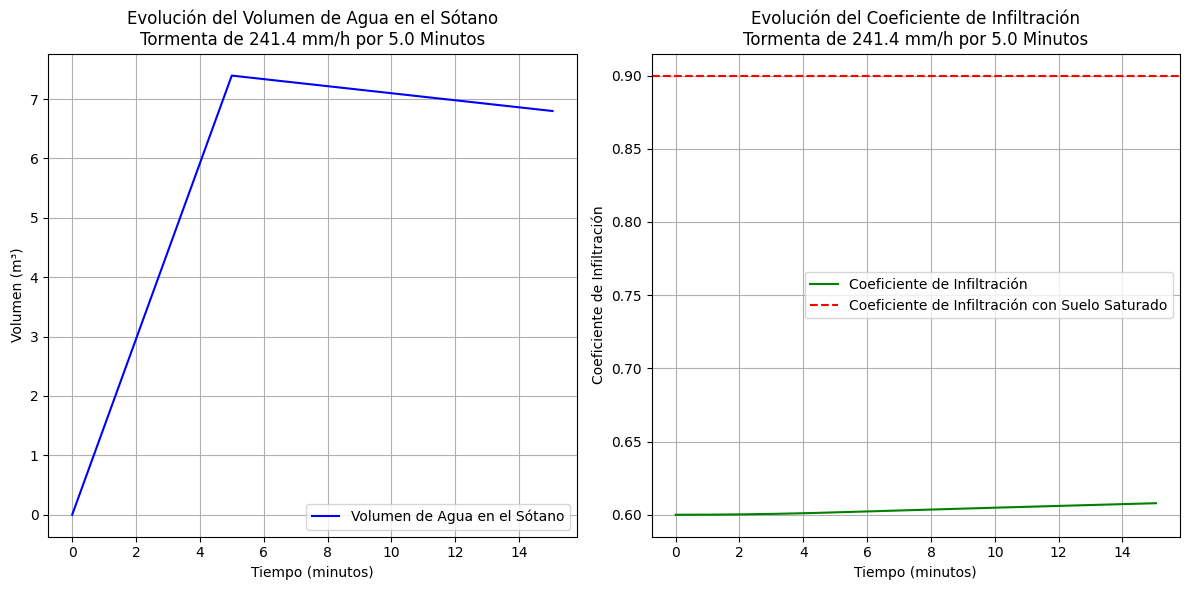

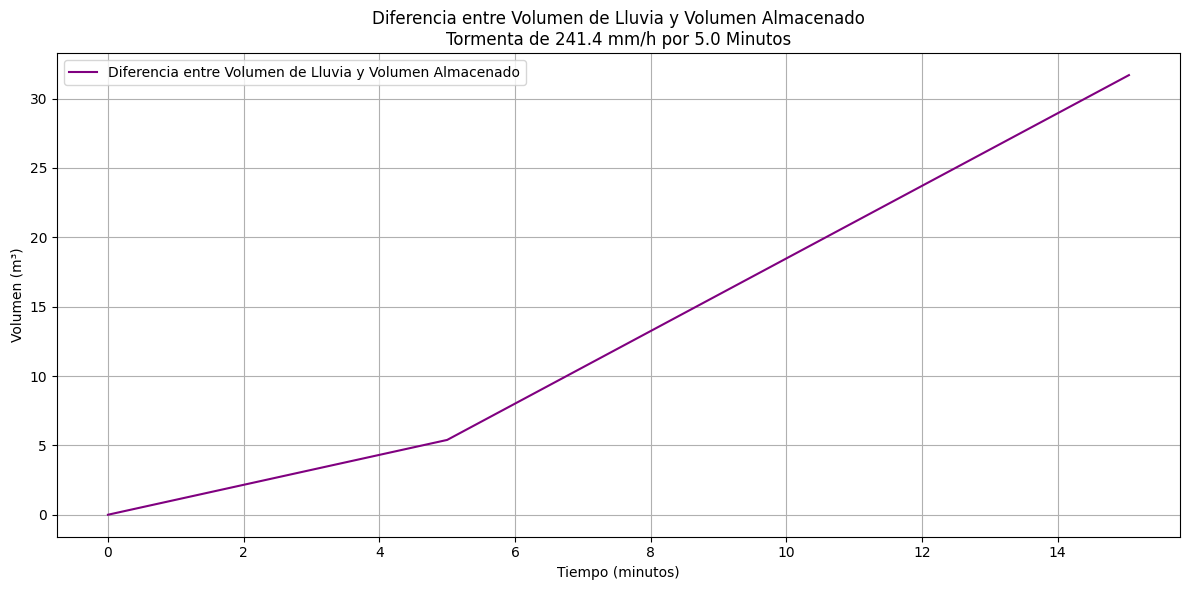

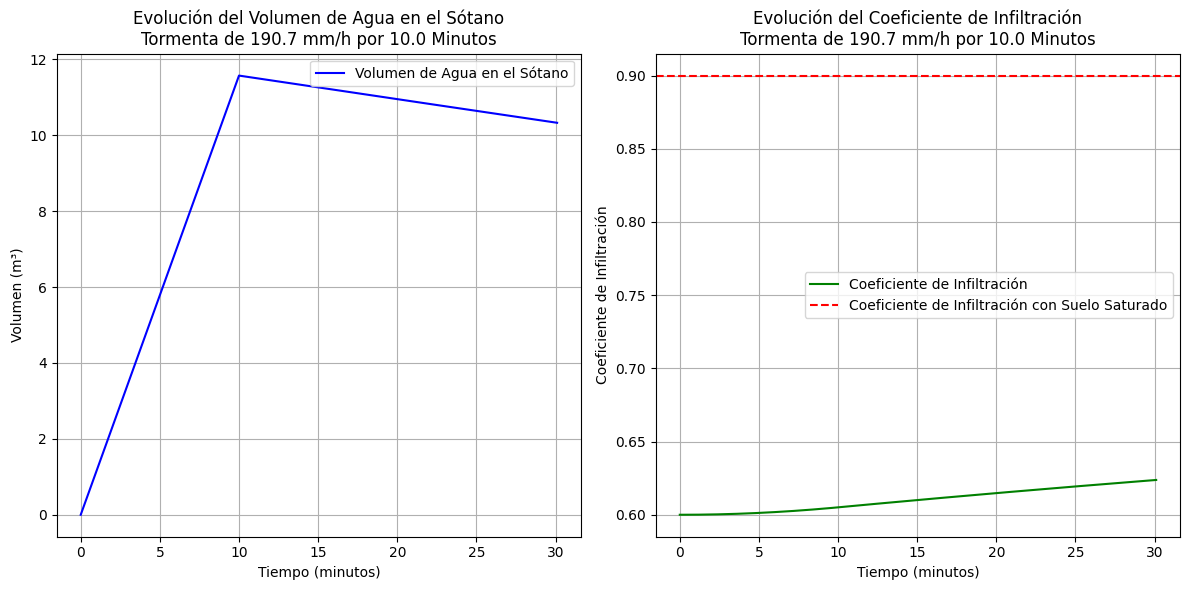

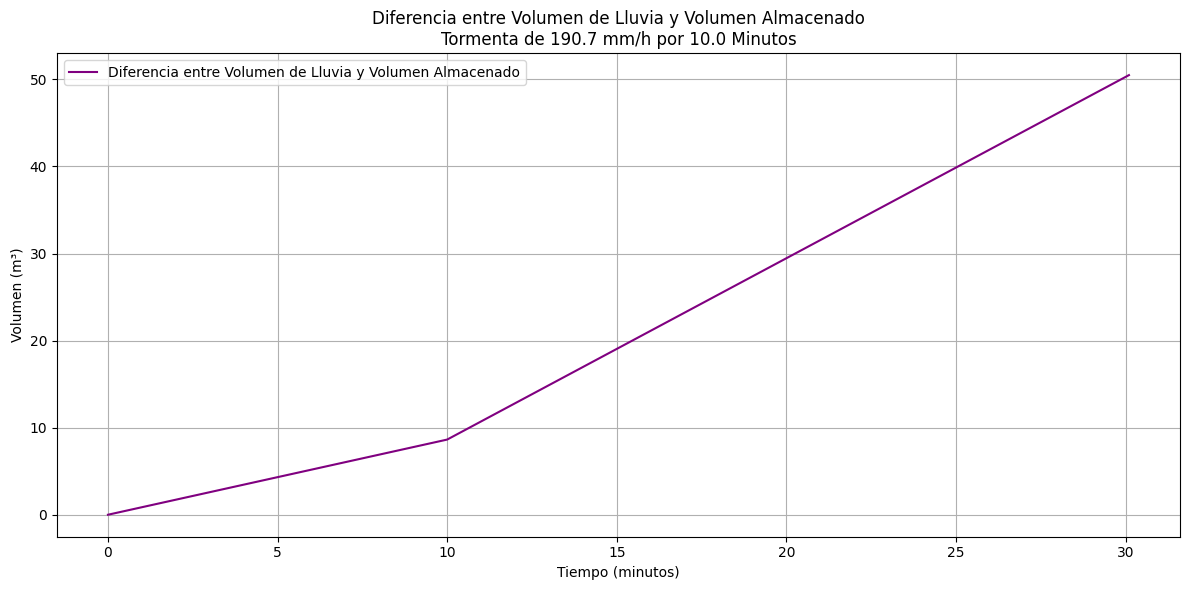

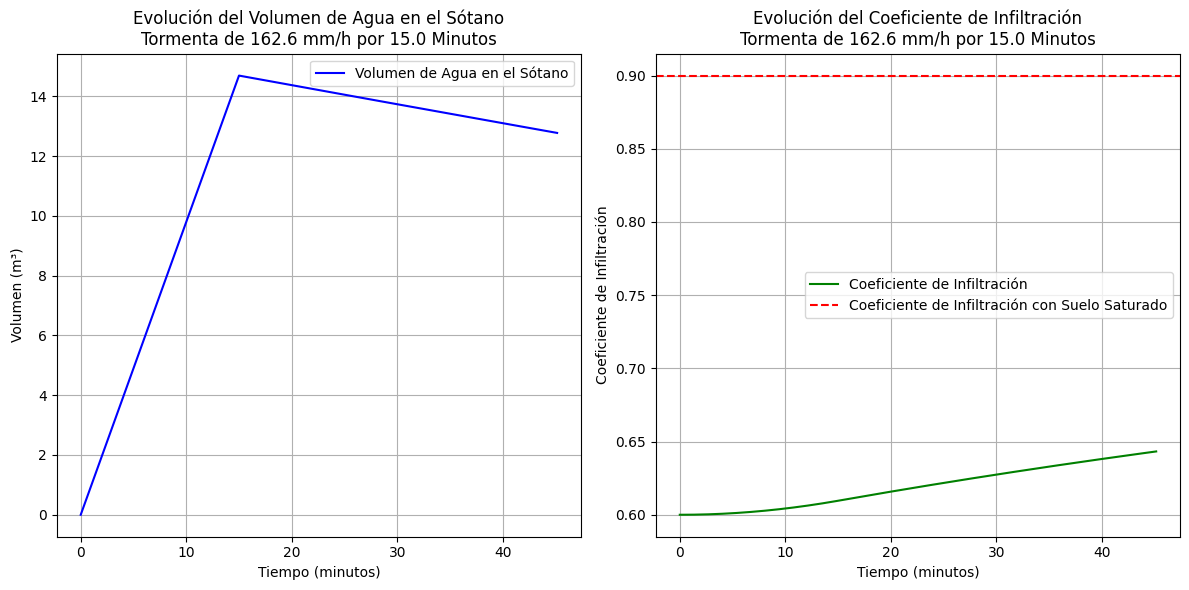

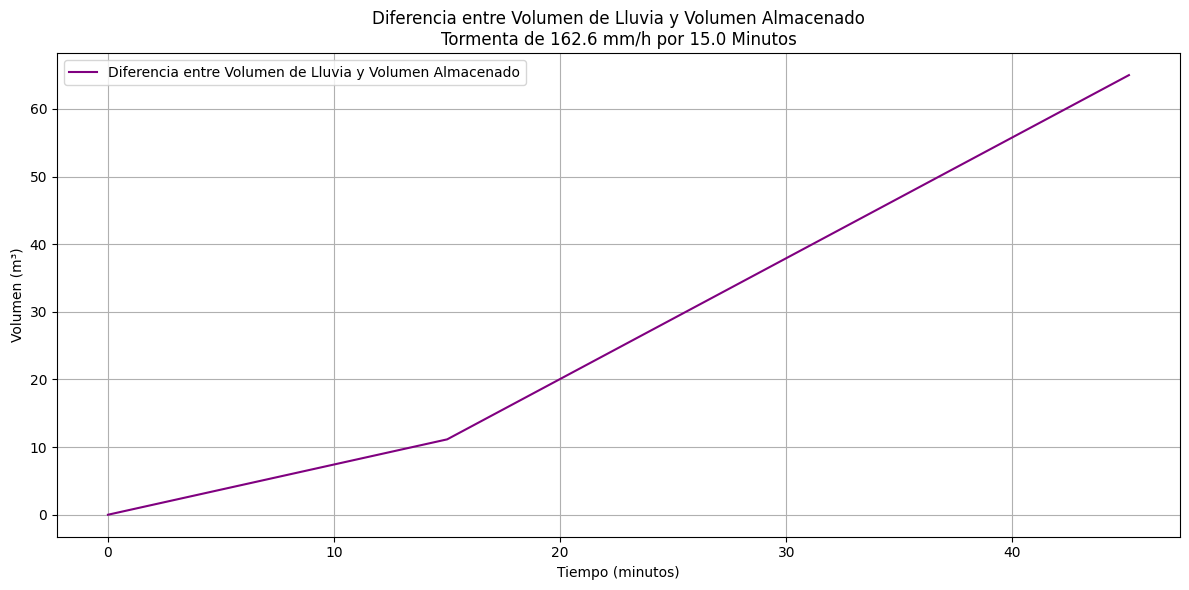

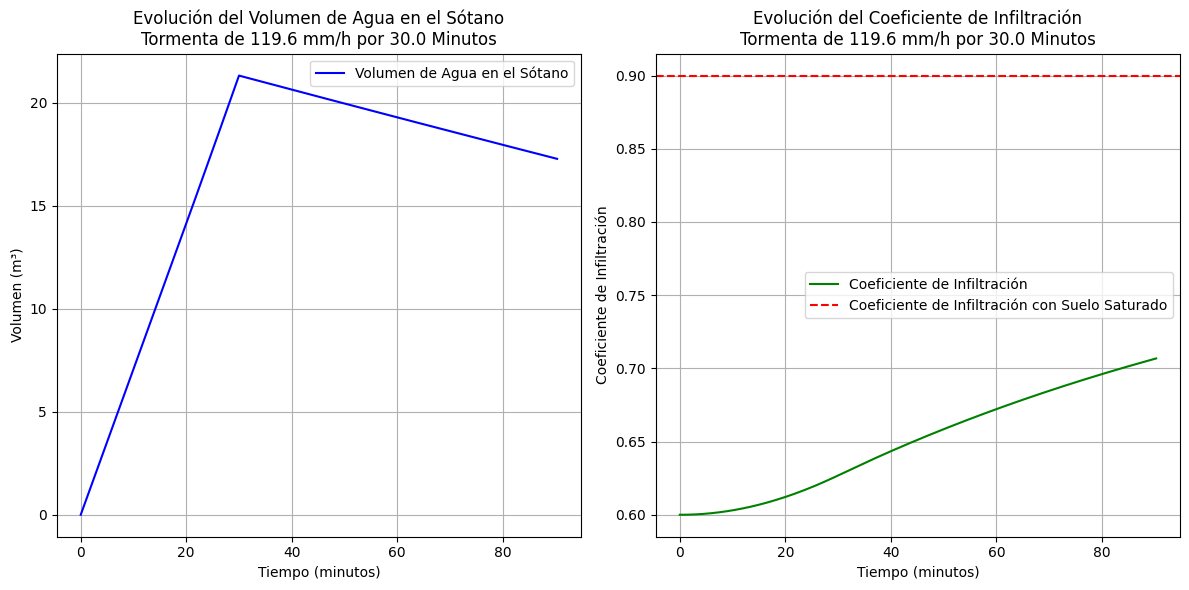

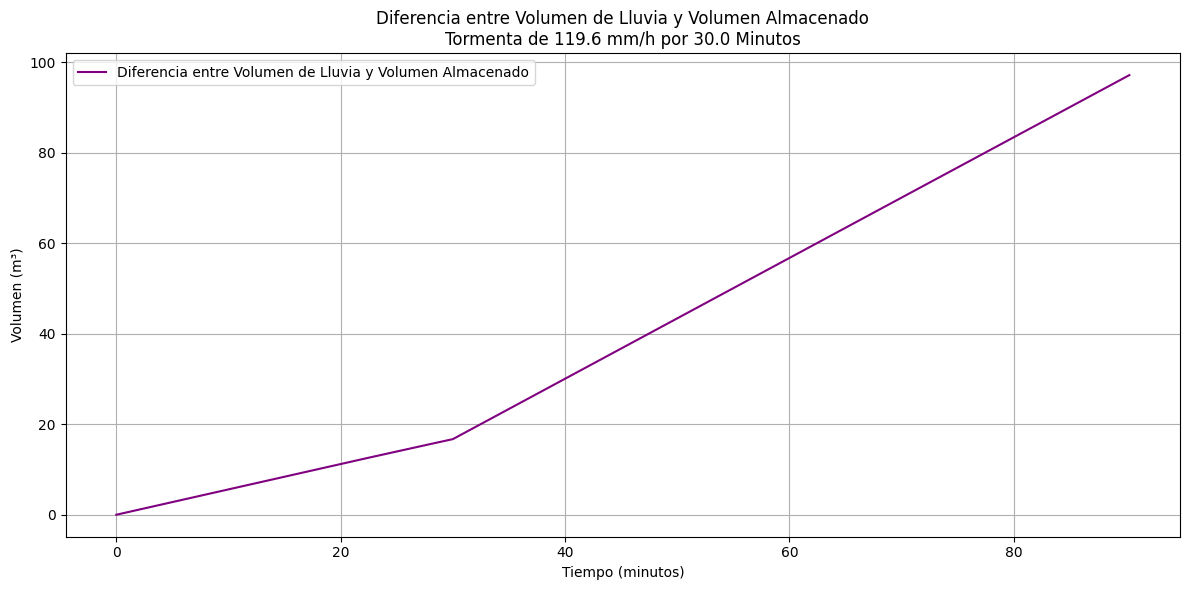

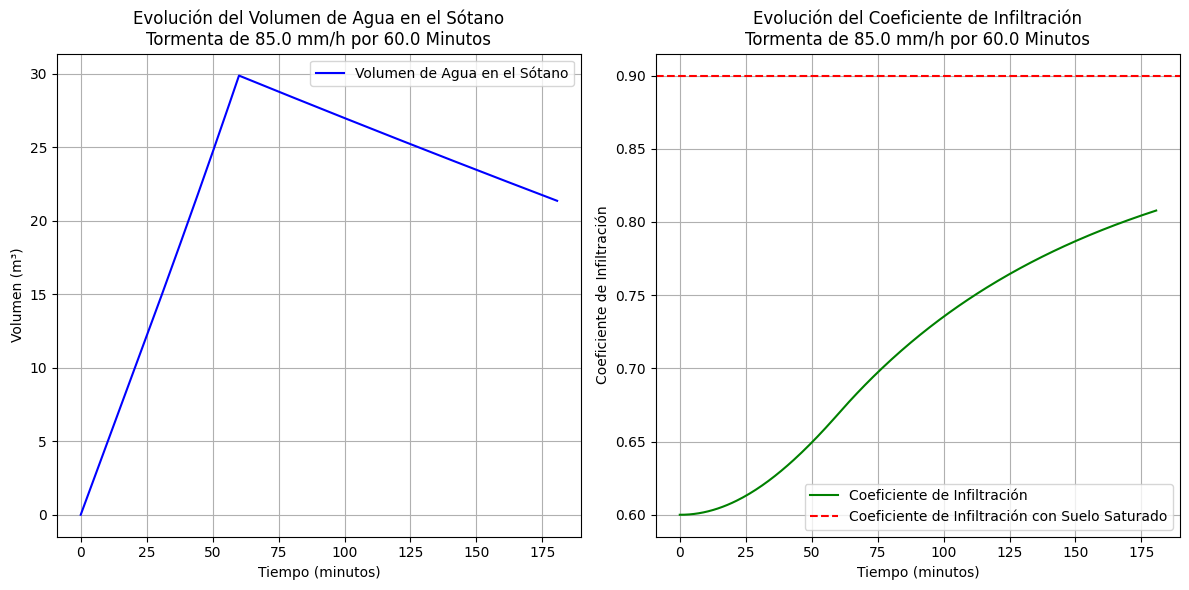

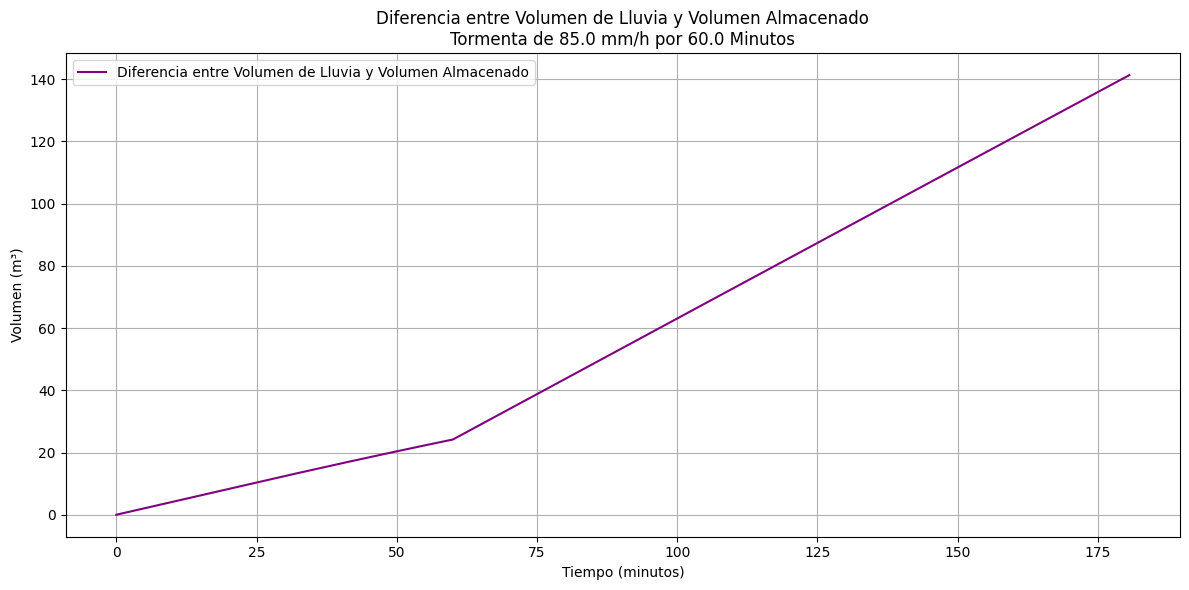

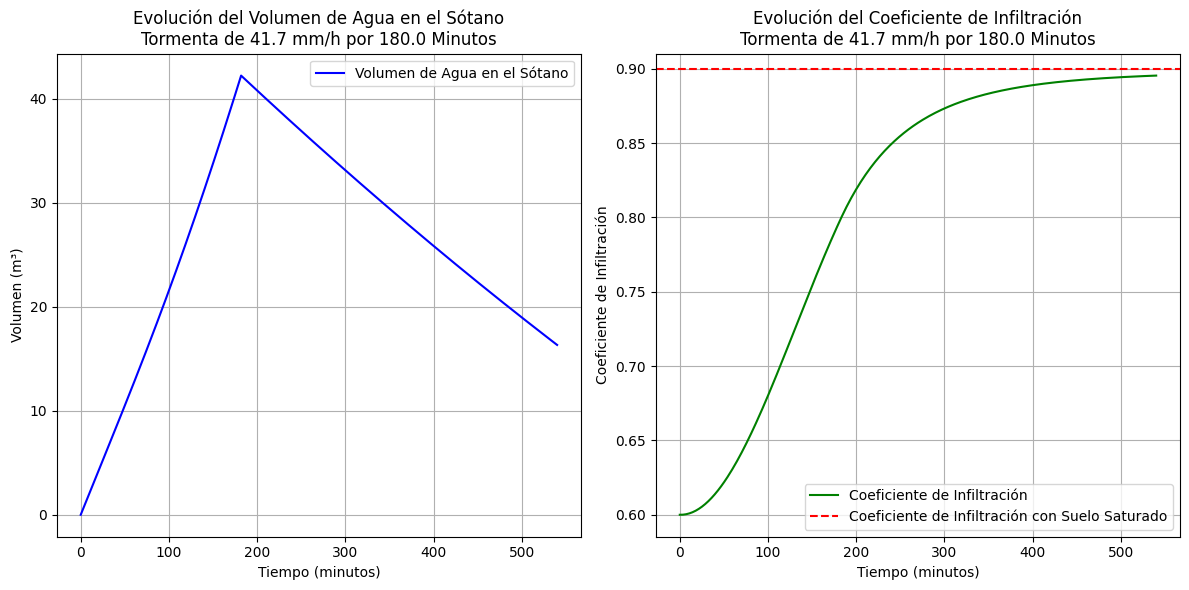

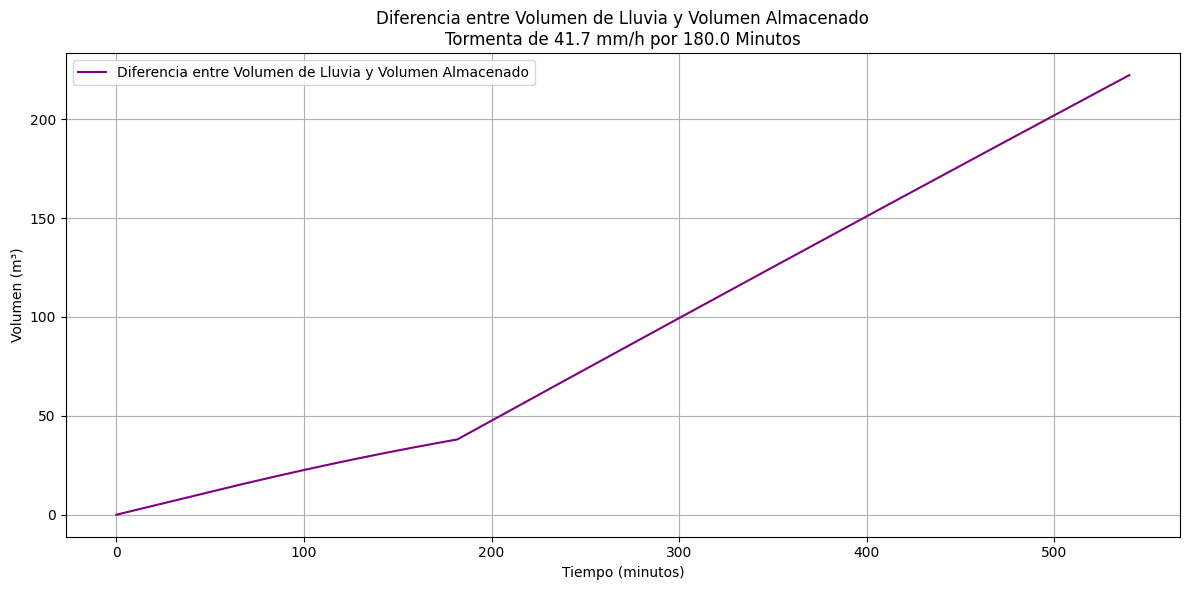

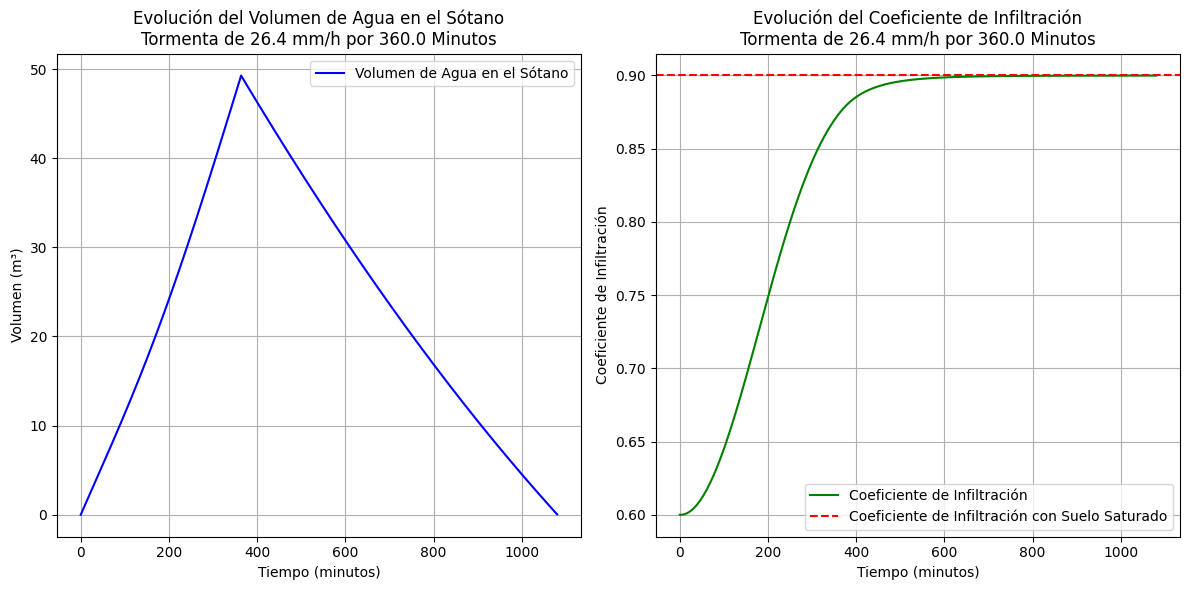

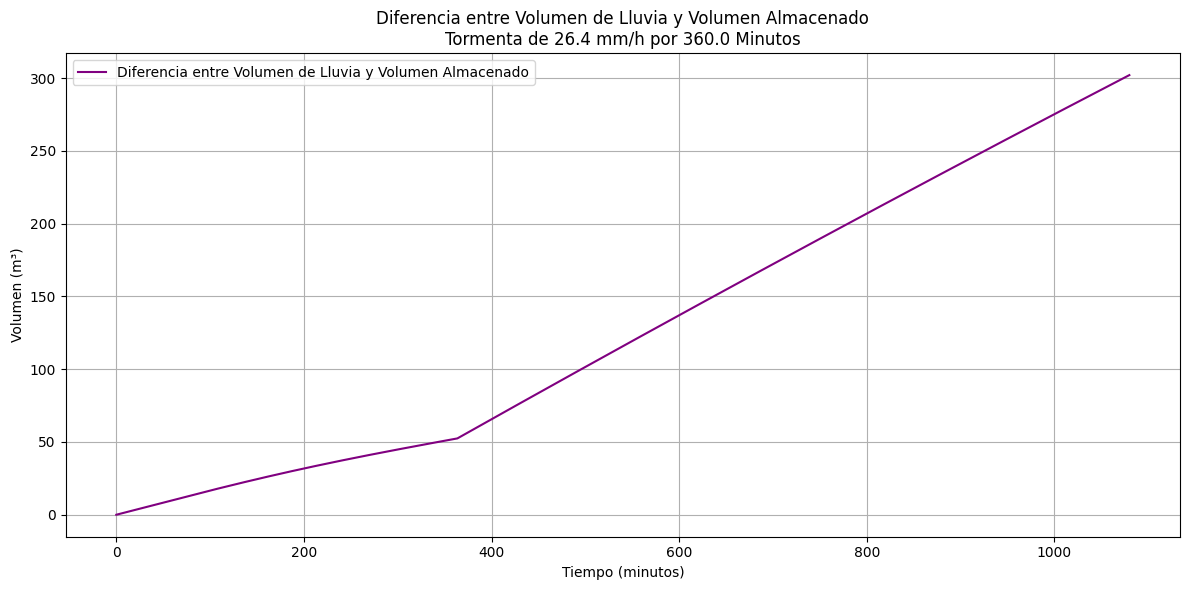

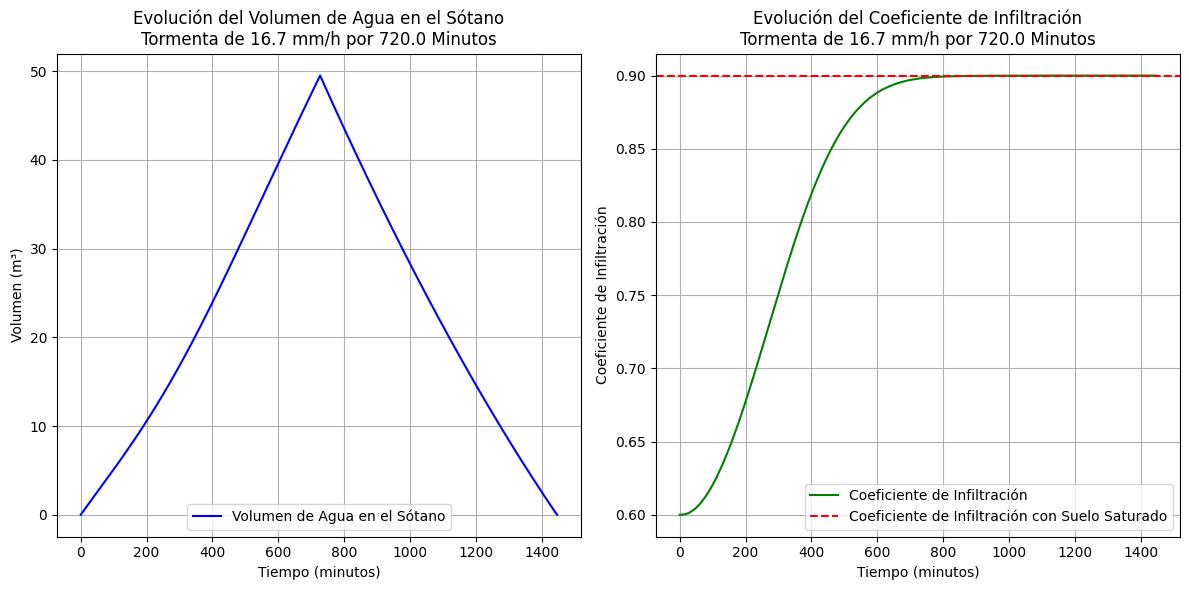

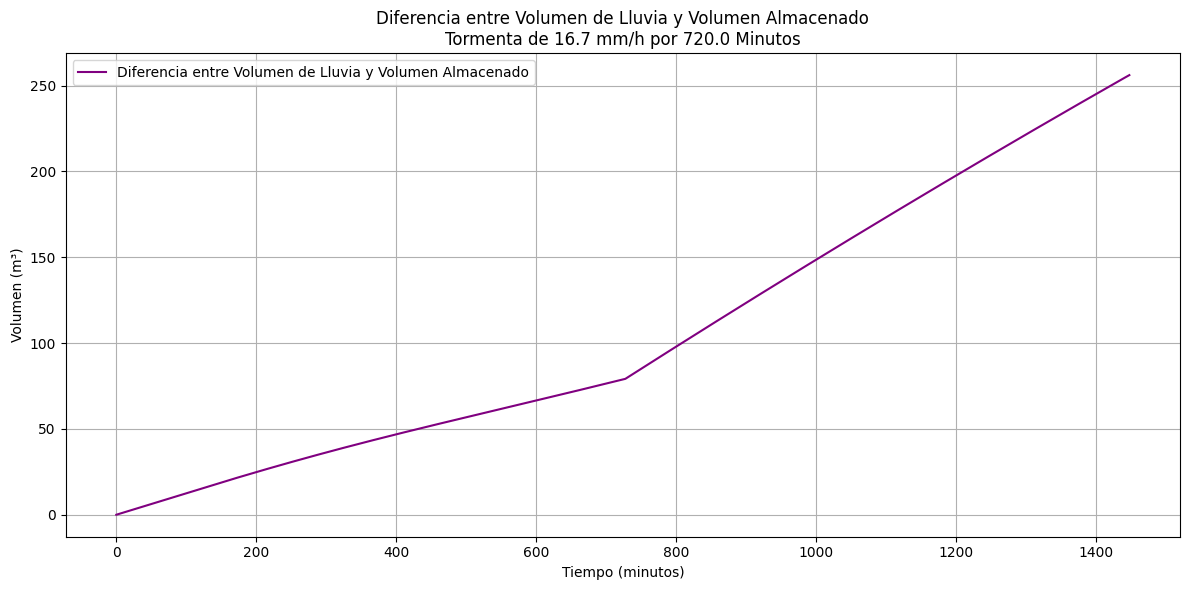

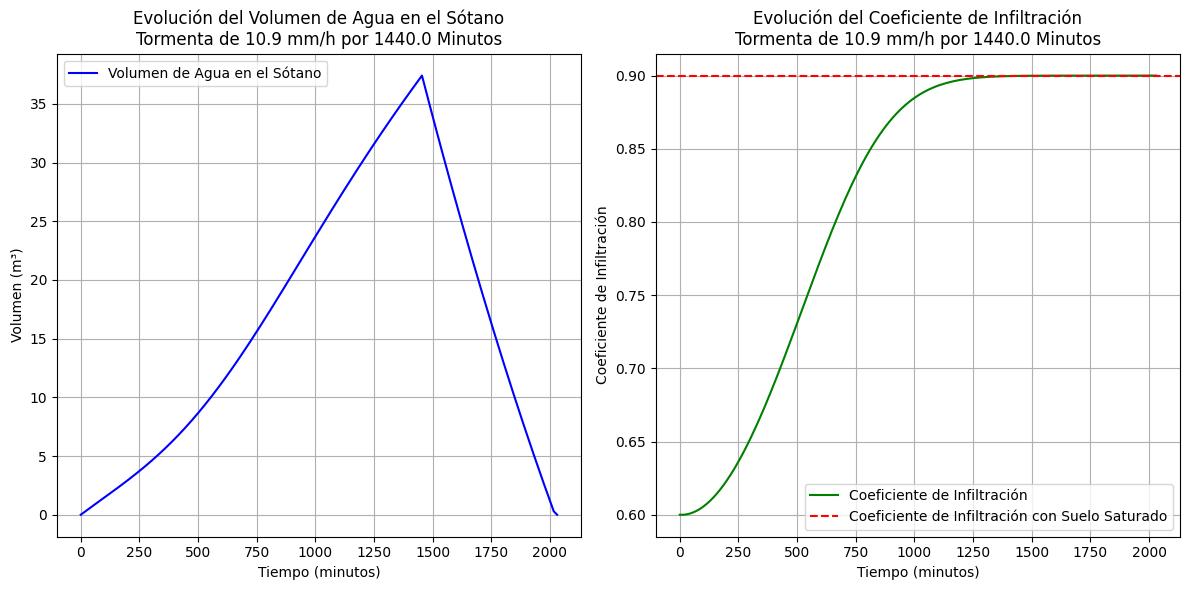

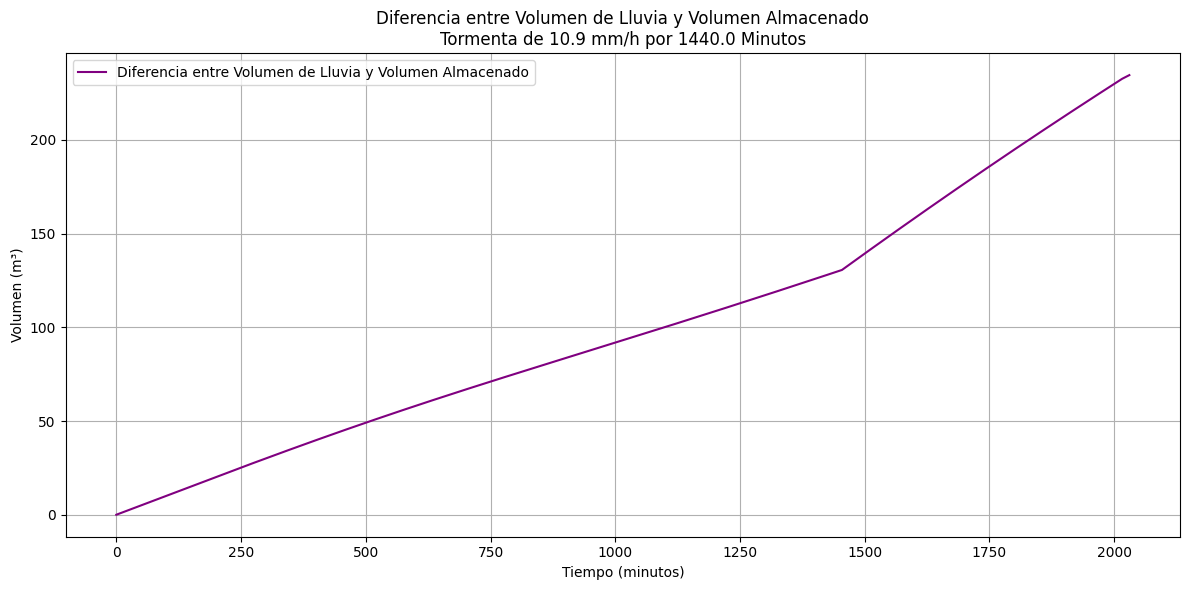

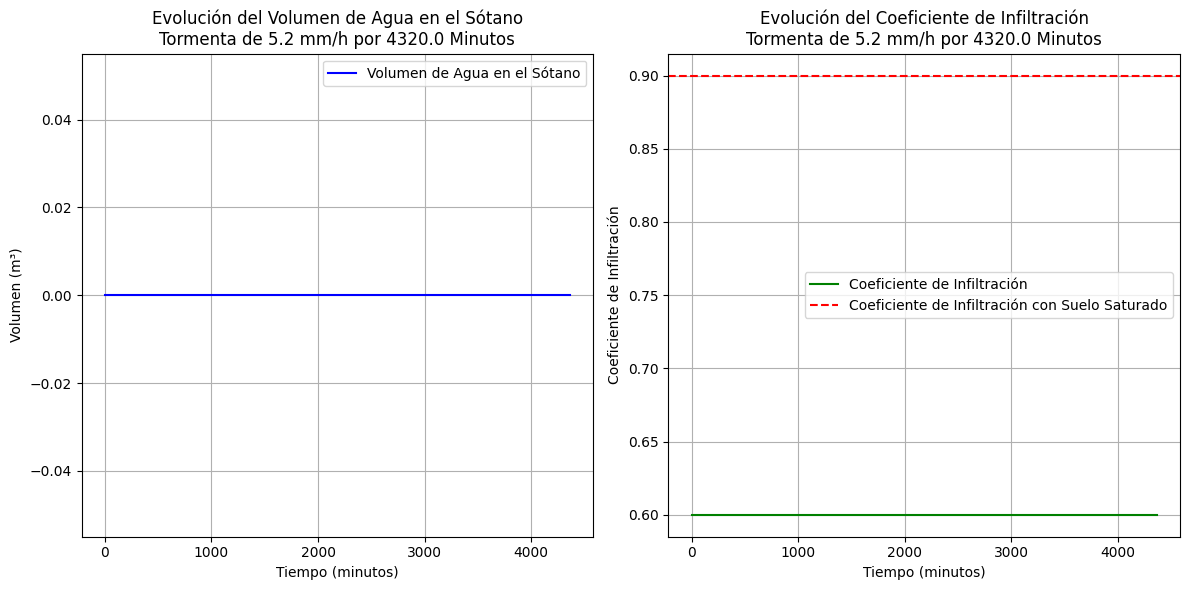

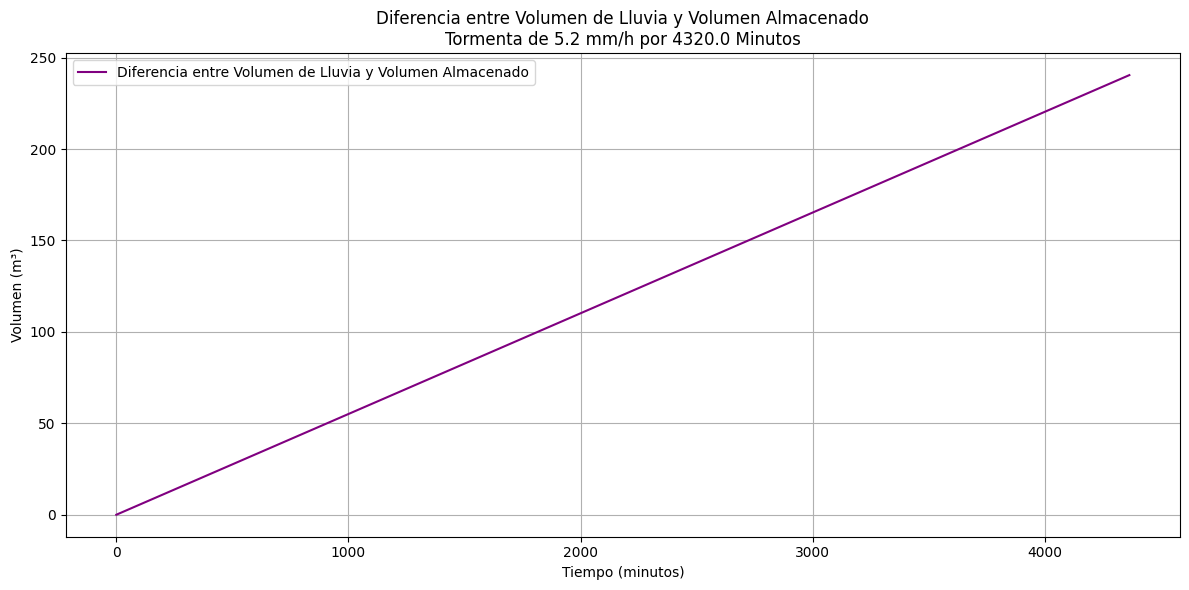

In [279]:
for duracion_tormenta, intensidad_tormenta, volumenes, infiltraciones, d_tiempo, caudales_entrada, caudales_salida in historial_tormentas:
    tiempos = [i * d_tiempo * 60 for i in range(len(volumenes))]
    volumen_total_lluvia = [d_tiempo * intensidad_tormenta * A_TERR * i for i in range(len(volumenes))]
    diferencias_volumenes = [volumen_total_lluvia[i] - volumenes[i] for i in range(len(volumenes))]

    # Figura 1: Volumen de agua y coeficiente de infiltración
    plt.figure(figsize=(12, 6))  

    # Evolución del Volumen de Agua en el Sótano
    plt.subplot(1, 2, 1)
    plt.plot(tiempos, volumenes, label='Volumen de Agua en el Sótano', color='blue')
    plt.xlabel('Tiempo (minutos)')
    plt.ylabel('Volumen (m³)')
    plt.title(f'Evolución del Volumen de Agua en el Sótano\nTormenta de {intensidad_tormenta*1000} mm/h por {duracion_tormenta*60} Minutos')
    plt.legend()
    plt.grid(True)

    # Evolución del Coeficiente de Infiltración
    plt.subplot(1, 2, 2)
    plt.plot(tiempos, infiltraciones, label='Coeficiente de Infiltración', color='green')
    plt.axhline(y=C_SAT, color='r', linestyle='--', label='Coeficiente de Infiltración con Suelo Saturado')
    plt.xlabel('Tiempo (minutos)')
    plt.ylabel('Coeficiente de Infiltración')
    plt.title(f'Evolución del Coeficiente de Infiltración\nTormenta de {intensidad_tormenta*1000} mm/h por {duracion_tormenta*60} Minutos')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Figura 2: Diferencia entre Volumen de Lluvia y Volumen Almacenado
    plt.figure(figsize=(12, 6))
    plt.plot(tiempos, diferencias_volumenes, label='Diferencia entre Volumen de Lluvia y Volumen Almacenado', color='purple')
    plt.xlabel('Tiempo (minutos)')
    plt.ylabel('Volumen (m³)')
    plt.title(f'Diferencia entre Volumen de Lluvia y Volumen Almacenado\nTormenta de {intensidad_tormenta*1000} mm/h por {duracion_tormenta*60} Minutos')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## B 

Dimensionamiento de la bomba. Redimensionar la bomba adoptando un nuevo $Q_{max}$
para que la altura de agua sobre el piso del sótano no exceda los 0,25m para ninguna de las precipitaciones de la tabla.

In [280]:
def d_volumen(volumen, infiltracion, tiempo, caudal_maximo, intensidad):
    area_del_terreno = A_TERR

    flujo_maximo = caudal_maximo
    d_altura_maxima = D_H_MAX
    d_altura_minima = D_H_MIN

    altura_sotrano = H_SOT
    area_sotano = A_SOT
    volumen = f_altura_agua(volumen, area_sotano)

    desnivel_agua = f_desnivel_agua(altura_sotrano, volumen)
    caudal_entrada = f_caudal_entrada(infiltracion, intensidad, area_del_terreno)
    caudal_salida = f_caudal_salida(
        flujo_maximo, d_altura_maxima, d_altura_minima, desnivel_agua
    )

    return f_derivada_volumen(caudal_entrada, caudal_salida)


def d_infiltracion(volumen, infiltration, tiempo):

    volumen_sotano = V_SOT

    tiempo_caracteristico = T_K
    infiltracion_saturado = C_SAT

    return f_derivada_infiltracion(
        volumen,
        volumen_sotano,
        tiempo_caracteristico,
        infiltracion_saturado,
        infiltration,
    )


def test(caudal_maximo):
    for duracion_tormenta, intensidad_tormenta in tormentas:
        tiempo_actual = 0

        volumen = 0

        infiltracion = C_0

        d_tiempo = duracion_tormenta / 100  # 100 pasos de tiempo por tormenta

        while tiempo_actual < duracion_tormenta:

            du = d_tiempo * d_volumen(
                volumen, infiltracion, tiempo_actual, caudal_maximo, intensidad_tormenta
            )
            dv = d_tiempo * d_infiltracion(volumen, infiltracion, tiempo_actual)

            volumen = volumen + du
            infiltracion = infiltracion + dv

            volumen = max(0, volumen)

            tiempo_actual += d_tiempo
            altura_agua = f_altura_agua(volumen, A_SOT)

            if altura_agua > h_lim:
                return False

    return True


intensidad_maxima = max([intensidad for _, intensidad in tormentas])
h_lim = 0.25
d_h_lim = H_SOT - h_lim
factor_en_h_lim = (D_H_MAX - d_h_lim / D_H_MAX - D_H_MIN) ** 0.5


def busqueda_binaria(inicio, fin, iteraciones):
    if iteraciones == 0:
        return fin

    mitad = (inicio + fin) / 2

    if test(mitad):
        return busqueda_binaria(inicio, mitad, iteraciones - 1)
    else:
        return busqueda_binaria(mitad, fin, iteraciones - 1)


caudal_maximo_inicial = Q_MAX  # la tormenta ya calculada, que NO pasa el test
caudal_maximo_limite = (
    C_SAT * intensidad_maxima * A_TERR / factor_en_h_lim
)  # caudal calculado teoricamente que pasa el test

iteraciones = 32  # es decir, el error respecto al óptimo es < (caudal_maximo_limite - caudal_maximo_inicial) 2^-32

caudal_maximo = busqueda_binaria(
    caudal_maximo_inicial, caudal_maximo_limite, iteraciones
)

print(f"El caudal máximo es: {caudal_maximo} m3/h")

El caudal máximo es: 31.879595972619704 m3/h


## C
Discretizar las ec. 1 y ec. 6 con el método de Runge-Kutta de orden 2

In [281]:
def d_volumen(volumen, infiltracion, tiempo):
    area_del_terreno = A_TERR

    flujo_maximo = Q_MAX
    d_altura_maxima = D_H_MAX
    d_altura_minima = D_H_MIN

    altura_sotrano = H_SOT
    area_sotano = A_SOT
    volumen = f_altura_agua(volumen, area_sotano)

    desnivel_agua = f_desnivel_agua(altura_sotrano, volumen)
    caudal_entrada = f_caudal_entrada(infiltracion, intensidad, area_del_terreno)
    caudal_salida = f_caudal_salida(
        flujo_maximo, d_altura_maxima, d_altura_minima, desnivel_agua
    )

    return f_derivada_volumen(caudal_entrada, caudal_salida)


def d_infiltracion(volumen, infiltration, tiempo):

    volumen_sotano = V_SOT

    tiempo_caracteristico = T_K
    infiltracion_saturado = C_SAT

    return f_derivada_infiltracion(
        volumen,
        volumen_sotano,
        tiempo_caracteristico,
        infiltracion_saturado,
        infiltration,
    )

duracion_tormenta = 1
intensidad_tormenta = 85 / 1000
d_tiempo = 1 / 60

tiempo_actual = 0
volumen = 0
infiltration = C_0

intensidad = intensidad_tormenta

while tiempo_actual < duracion_tormenta:
    volumen, infiltration = runge_kutta_2(
        d_volumen, d_infiltracion, volumen, infiltration, tiempo_actual, d_tiempo
    )

    volumen = max(0, volumen)

    tiempo_actual += d_tiempo

print(f"El volumen de agua en el sotano una vez terminada la tormenta es de {volumen} m3")

intensidad = 0

while volumen > 0:
    volumen, infiltration = runge_kutta_2(
        d_volumen, d_infiltracion, volumen, infiltration, tiempo_actual, d_tiempo
    )

    volumen = max(0, volumen)

    tiempo_actual += d_tiempo

print(f"El tiempo que tarda en vaciarse el sotano es de {tiempo_actual} horas")

El volumen de agua en el sotano una vez terminada la tormenta es de 29.88951807057908 m3
El tiempo que tarda en vaciarse el sotano es de 8.833333333333352 horas
